## TalkingData AdTracking Fraud Detection Challenge - Oded Ben Chetrit

### Data Description
For this competition, the objective is to predict whether a user will download an app after clicking a mobile app advertisement.

File descriptions - train.csv - the training set - train_sample.csv - 100,000 randomly-selected rows of training data, to inspect data before downloading full set. This can help you in a basic EDA process. - test.csv - the test set - sampleSubmission.csv - a sample submission file in the correct format

#### Data fields
Each row of the training data contains a click record, with the following features.

 - ip: ip address of click, meaning the IP "source" address where a user clicked from (device).
 - app: app id (each app has 1 id).
 - device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
 - os: os version id of user mobile phone
 - channel: channel id of mobile ad publisher
 - click_time: timestamp of click (UTC)
 - attributed_time: if user download the app for after clicking an ad, this is the time of the app download
 - is_attributed: the target that is to be predicted, indicating the app was downloaded (i.e. Y / Y_hat)

In [3]:
# Import packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterSampler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [4]:
# Import Data
train_sample = pd.read_csv('train_sample.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train_sample

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,NaN,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,NaN,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,NaN,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,NaN,0


In [5]:
train.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26877324 entries, 0 to 26877323
Data columns (total 8 columns):
 #   Column           Non-Null Count     Dtype 
---  ------           --------------     ----- 
 0   ip               26877324 non-null  int64 
 1   app              26877324 non-null  int64 
 2   device           26877324 non-null  int64 
 3   os               26877324 non-null  int64 
 4   channel          26877324 non-null  int64 
 5   click_time       26877324 non-null  object
 6   attributed_time  64876 non-null     object
 7   is_attributed    26877324 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.6+ GB


From the info method above, we can see that data is full without missing data. The only column with missing data is 'attributed_time',  and the missing data there is due to non clicked ads. So it makes sense. 
Also, as we can see below, there is consistency between the amount of non-null attributed_time data to the count of samples where is_attributed feature was 1.

In [4]:
np.sum(train.is_attributed == 1)

64876

The data is very imbalanced, only 0.24137819672821595% of the clicks ended in download of the apps


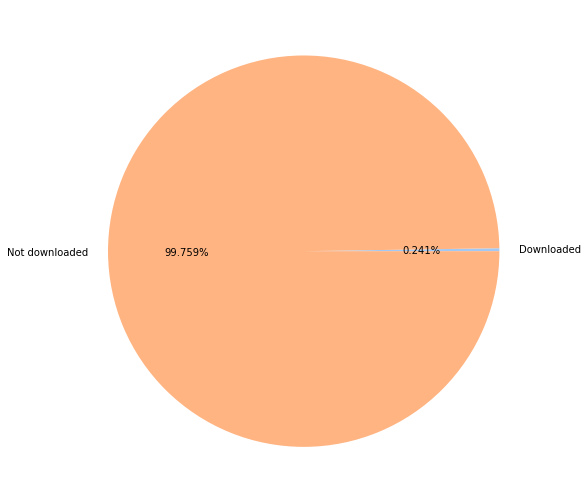

In [5]:
# total samples:
total_clicks = train.is_attributed.size

# total number of app downloads:
total_downloads = train.is_attributed.sum()

percent_downloads = 100 * total_downloads / total_clicks
percent_not_downloads = 100 - percent_downloads

print(f'The data is very imbalanced, only {percent_downloads}% of the clicks ended in download of the apps')
plt.figure(figsize = (12,9))
colors = sns.color_palette('pastel')[0:2]
plt.pie([percent_downloads, percent_not_downloads], labels = ['Downloaded', 'Not downloaded'] ,colors = colors, autopct='%.3f%%')
plt.show()

In [6]:
# Explore unique values in columns:
for col in train.columns:
    print(f'In column ["{col}"] there are {len(train[col].unique())} unique values out of {sum(train[col].notnull())}.\n')

In column ["ip"] there are 120090 unique values out of 26877324.

In column ["app"] there are 459 unique values out of 26877324.

In column ["device"] there are 1551 unique values out of 26877324.

In column ["os"] there are 398 unique values out of 26877324.

In column ["channel"] there are 185 unique values out of 26877324.

In column ["click_time"] there are 47858 unique values out of 26877324.

In column ["attributed_time"] there are 38493 unique values out of 64876.

In column ["is_attributed"] there are 2 unique values out of 26877324.



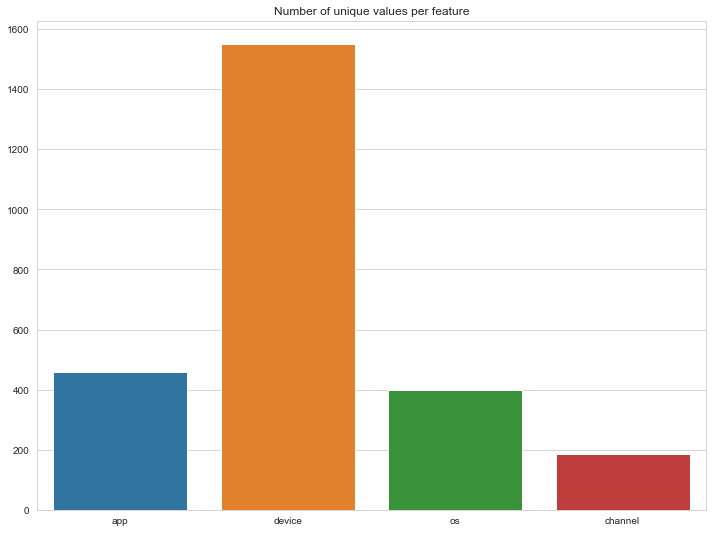

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize = (12,9))
cols = ['app', 'device', 'os', 'channel']
g = sns.barplot(x = cols, y = [len(train[col].unique()) for col in cols])
plt.title('Number of unique values per feature')
plt.show()

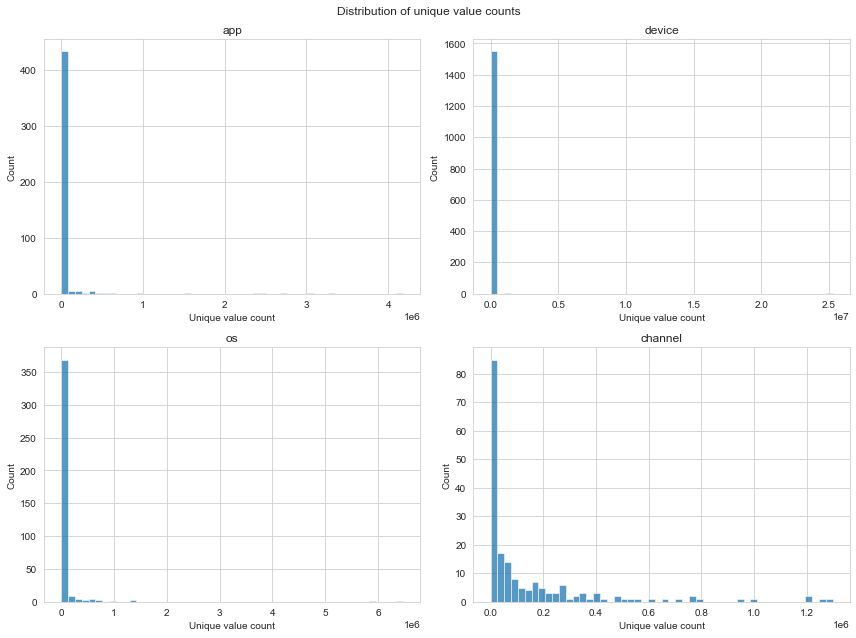

In [8]:
cols = ['app', 'device', 'os', 'channel']
plt.figure(figsize = (12,9))
plt.suptitle('Distribution of unique value counts')
for i,col in enumerate(cols):
    plt.subplot(2,2,i+1)
    sns.histplot(train[col].value_counts(),bins = 50)
    plt.xlabel('Unique value count')
    plt.title(col)
plt.tight_layout()
plt.show()

As we can see, if we plot the value counts of the four categorical features in the data, there is a right tailed distribution in all categories. This means that in all features there are many unique values of attributes that are used only by a few users. In contrary, there are also only few unique values of attributes that are used by many users for each feature. For example in the device feature, there are 1551 unique values, in which 94% of the users use device number '1' as you can see below.

In [12]:
# the percent of users using the most common device (which is device '1')
100 * train.device.value_counts(ascending = False).max() / train.device.count()

94.0163648732292

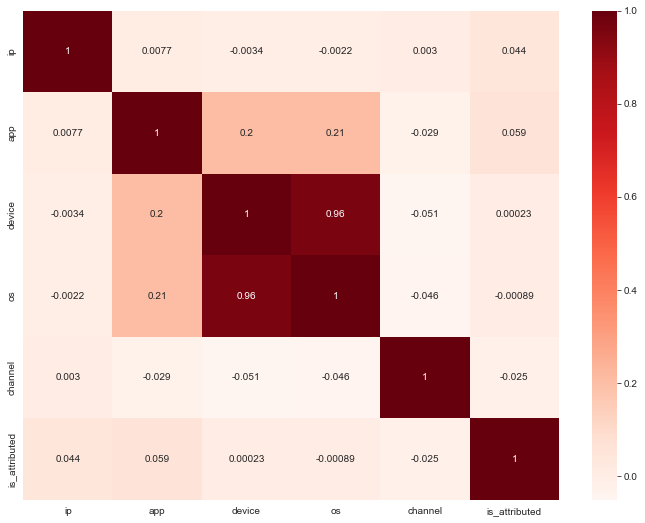

In [15]:
plt.figure(figsize = (12,9))
sns.heatmap(train.corr(), cmap="Reds", annot=True)
plt.show()

We can see in the correlation matrix that the device and OS features are highly correlated, and that there is a slight correlation between the app feature to the device and OS features.

#### Feature Engineering
The following function defines some basic feature engineering such as date time conversion to day/ hour/ minute/ second, drops unnecessary columns and converts some categorical features to type 'category'. We will apply this function on both train and test sets.   

In [27]:
# Feature Engineering: 
def feature_engineering(df):
    
    # Convert click_time to type date_time: 
    df['date'] = pd.to_datetime(df['click_time'])
    
    # Extruct features from date and time: 
    df['day'] = df['date'].dt.dayofweek.astype('uint16')
    df['hour'] = df['date'].dt.hour.astype('uint8')
    df['min'] = df['date'].dt.minute.astype('uint8')
    df['sec'] = df['date'].dt.second.astype('uint8')
    
    # Drop unused column:
    df.drop(['click_time'], axis= 1, inplace=True)
    
    # Convert categorical features to type category: 
    cols = ['app', 'device', 'os', 'channel']
    for col in cols:
        
        df[col] = df[col].astype('category')
        
    return df

In [28]:
# Apply Feature engineering: 
train = feature_engineering(train)
test = feature_engineering(test)

In [6]:
train

,ip,app,device,os,channel,attributed_time,is_attributed,date,day,hour,min,sec
0,83230,3,1,13,379,NaN,0,2017-11-06 14:32:21,0,14,32,21
1,17357,3,1,19,379,NaN,0,2017-11-06 14:33:34,0,14,33,34
2,35810,3,1,13,379,NaN,0,2017-11-06 14:34:12,0,14,34,12
3,45745,14,1,13,478,NaN,0,2017-11-06 14:34:52,0,14,34,52
4,161007,3,1,13,379,NaN,0,2017-11-06 14:35:08,0,14,35,8
...,...,...,...,...,...,...,...,...,...,...,...,...
26877319,83420,1,1,19,125,NaN,0,2017-11-07 00:52:39,1,0,52,39
26877320,102206,15,1,19,245,NaN,0,2017-11-07 00:52:39,1,0,52,39
26877321,111969,14,1,32,401,NaN,0,2017-11-07 00:52:39,1,0,52,39
26877322,6696,11,1,11,319,NaN,0,2017-11-07 00:52:39,1,0,52,39


#### Add clicks

Another feature engineering - We define a function that counts the number of clicks each user clicked and attach it to the user's row. 
Also we define a wrapper function for the add_click function, that takes the train and test datasets, merge them, applies the add_click function on the merged dataframe and then splits them back to the train and test sets. 

There can be a problem of data leakage with this type of operation, But since the test set is a continuation of the training set, this information can greatly add to the estimation algorithm.

In a real world data challenge, we would probably won't have the opportunity to do so, but since this is a kaggle compatition, we allow ourselves.  

In [29]:
# A function that adds another feature to the data:
# feature that counts number of clicks per ip and attaches the number of clicks to the ip's row:
def add_clicks(df):
    # Count clicks per ip: 
    num_clicks_ip = df.groupby('ip').size().reset_index()
    
    # Change column name: 
    num_clicks_ip = num_clicks_ip.rename(columns = {0:'clicks'})
    
    # Append clicks column to data frame by meging on 'ip': 
    return pd.merge(df, num_clicks_ip, on = 'ip', how = 'left')

In [30]:
# A function that concatinates the training and test data and computes number of clicks.
# then, separates it back to train and test:
def concat_and_split(train, test):
    train_copy = train.copy()
    test_copy = test.copy()
    df_merged = pd.merge(left = train_copy, right = test_copy, how='outer')
    df_merged = add_clicks(df_merged)
    train_copy['clicks'] = df_merged['clicks'][0:len(train_copy)].tolist()
    test_copy['clicks'] = df_merged['clicks'][len(train_copy)::].tolist()
    return train_copy, test_copy

Before we continue, we would like to explore more the distribution of usage along the time range, to do so we will plot an histogram of the date column, for the train and test datasets. Maybe we don't need to train the model over all the data.. we will check it out soon, but first let's explore the graph: 

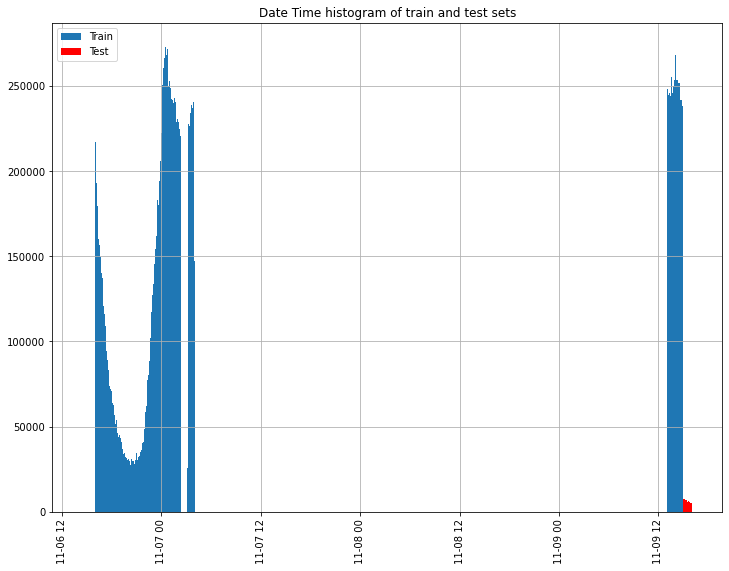

In [9]:
plt.figure(figsize = (12,9))
train.date.hist(bins = 1000, label = 'Train')
test.date.hist(bins = 500, color = 'red', label = 'Test')
plt.xticks(rotation='vertical')
plt.legend()
plt.title('Date Time histogram of train and test sets')
plt.show()

We notice a very strange behaviour of the training data.
There is a large empty interval in the middle, and also a small break at the beginning of the day 07/11. 

Later on, in the modeling stage we will try training the models with two types of training set, the first one will be comprised from the whole range of the training set, and the second will contain samples from the last part (after 12:00 of the 09/11).

#### Spliting the data

We first define the threshold which will split the data, and than define a function that gets a dataframe and splits it in the given threhold point. 

In [31]:
# Form the plot above we can easily see that there is a large area of missing data. 
# Maybe we can lay only on the training data that is closer to the test data --> the data that 
# is after 08/11/2017 - we can use this date for splitting the data: 
date_thresh = train[train.date > '2017-11-08']['date'].min()

print(f'The date and time in which the data continue after the break is: {date_thresh}')

The date and time in which the data continue after the break is: 2017-11-09 13:00:19


In [32]:
# A function that splits the training data and saves only the final part according to threshold: 
def split_data(df, thresh):
    return df[(df.date > thresh)]

#### Downsampling

Since the data is very imbalanced - 99.75% / 0.25% is the ratio between labeled = 0 / labeled = 1, in the "is_attributed" column which is the prediction column, and also from computational issues of running time, we decided to downsample the data using random sampler without replacement. This is done to the training set (original or spliitted) 

In [44]:
# A function for downsampling the training data labeled as "is_attributed" == 0:
def downsample(df, n=500000, seed=1):
    
    # apply downsampling on the training data by randomly omit samples that are labeled 
    # is_attributed == 0 --> this way we narrow the size of the data for computational issues 
    # and also fixing a bit the extreme imbalanced ratio between is_attributed 0/1:
    
    # random sample without replacement from ['is_attributed'] == 0 part
    df_downsampled = df[df['is_attributed'] == 0].sample(n=n, random_state = seed, replace = False)
    
    # concat with ['is_attributed'] == 1 part and return fixed data:
    return pd.concat([df_downsampled, df[df['is_attributed'] == 1]])

#### Proccess data for modeling

After defining different feature engineering functions, and data reductions, the last part is to drop final unnecessary columns and convert data to numpy type - ready for modeling. 

In [39]:
# Helper function to create X, y from data frame ready to train:
def convert_train(df):
    
    df = df.sort_values('date')
    
    # Obtain labels: 
    y = df['is_attributed'].values
    
    # Drop unused columns and obtain features:
    cols = ['ip', 'attributed_time', 'is_attributed', 'date']
    X = df.drop(columns = cols).values
    
    return X, y

In [40]:
# Helper function to create X from data frame ready to test:
def convert_test(df):
      
    # Drop unused columns and obtain features:
    cols = ['click_id', 'ip', 'date']
    X = df.drop(columns = cols).values
    
    return X

We will create different training sets according to the different functions above, and we'll explore if different changes in the data actually make change in the validation accuracy. 

In [ ]:
# Create dataset with number of clicks feature: 
train_clicks, test_clicks = concat_and_split(train, test)

In [ ]:
# Create two more data sets:
# Split data and use only the part of 09/11, do it for both train and train_clicks:
train_split = split_data(train, date_thresh)
train_clicks_split = split_data(train_clicks, date_thresh)

In [17]:
# So now we have 4 training data sets, let's downsample them all:
train = downsample(train)
train_clicks = downsample(train_clicks)
train_split = downsample(train_split)
train_clicks_split = downsample(train_clicks_split)

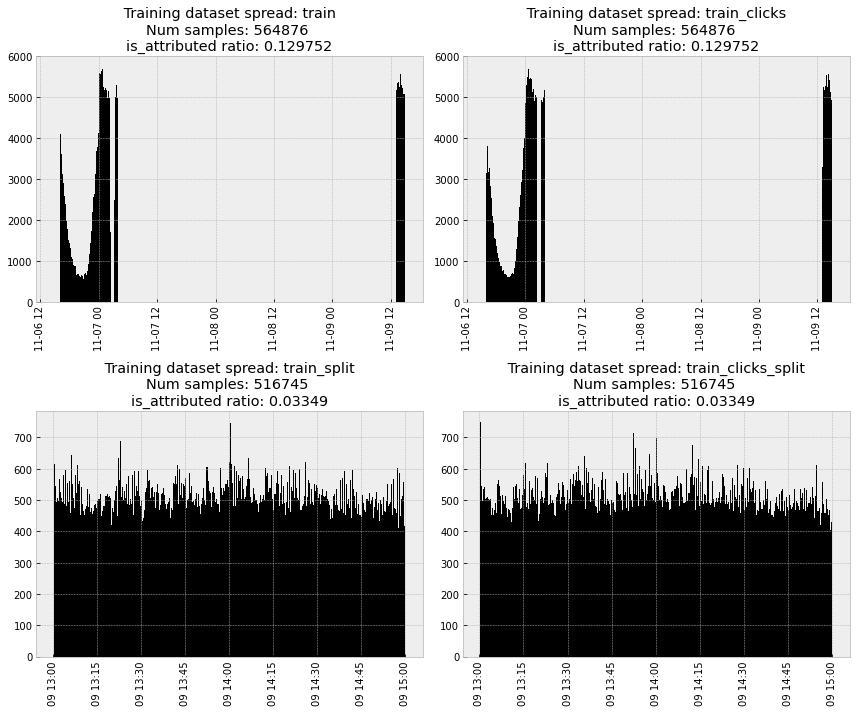

In [18]:
# let's review the training data sets we created: 
import random
datas = {'train' : train, 'train_clicks' : train_clicks,
         'train_split' : train_split, 'train_clicks_split' : train_clicks_split}
plt.style.use("bmh")
plt.figure(figsize=(12,10))
for i,d in enumerate(datas):
    plt.subplot(2,2,i+1)
    datas[d].date.hist(bins = 1000, color = 'k')
    plt.xticks(rotation='vertical')
    N = len(datas[d])
    R = len(datas[d][datas[d]['is_attributed'] == 1]) / len(datas[d][datas[d]['is_attributed'] == 0])
    plt.title(f' Training dataset spread: {d} \nNum samples: {N} \nis_attributed ratio: {R}')
plt.tight_layout()
plt.show()

Now, after creating 4 tpyes of training sets, lest convert them to numpy array to be ready before modeling: 

#### Convert to Numpy: 

In [19]:
X, y = convert_train(train)
X_clicks, y_clicks = convert_train(train_clicks)
X_split, y_split = convert_train(train_split)
X_clicks_split, y_clicks_split = convert_train(train_clicks_split)

### only for later use, let's convert the test set aswell: 
### Remember - the validation is not done on the test set, but with cross validation

# We need a test set with and without click feature: 
X_test = convert_test(test)
X_test_clicks = convert_test(test_clicks)

#### Modeling stage:

In [105]:
# Helper function that given a model and dataset creates train / validation split,
# fits the model, and computes the auc score: 
def fit_and_auc_score(model, X, y, X_Test, is_splitted = False, return_model = False):
    
    if not is_splitted:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
    # If the data is splitted and only the final part remains, we want to keep the order of the
    # data, so it will be similar to the real test data. 
    # when we do not perform the split, the time line is already very messy so it doesn't matter..
    # In this case we will use the random train_test_split... 
    else: 
        s = int(X.shape[0]*0.8)
        X_train = X[0:s,:]
        X_val = X[s::,:]
        y_train = y[0:s]
        y_val = y[s::] 
        
    model.fit(X_train, y_train)
    
    y_proba = model.predict_proba(X_train)
    y_val_proba = model.predict_proba(X_val)
    
    model.fit(X, y)
    
    # If return_model is True we return the model for late use.. 
    if return_model:
        return roc_auc_score(y_train, y_proba[:,1]), roc_auc_score(y_val, y_val_proba[:,1]), model
        
    return roc_auc_score(y_train, y_proba[:,1]), roc_auc_score(y_val, y_val_proba[:,1]), model.predict_proba(X_Test)

#### Decision Tree:

In [21]:
DT = DecisionTreeClassifier()

In [22]:
# Simple data:
DT_auc_train, DT_auc_val, DT_test = fit_and_auc_score(DT, X, y, X_test)
print(f'train auc: {DT_auc_train}, validation auc: {DT_auc_val}')

train auc: 0.9999978402252309, validation auc: 0.8712193819223099


In [23]:
# Data with clicks:
DT_auc_train_clicks, DT_auc_val_clicks, DT_test_clicks = fit_and_auc_score(DT, X_clicks, y_clicks, X_test_clicks)
print(f'train auc: {DT_auc_train_clicks}, validation auc: {DT_auc_val_clicks}')

train auc: 0.999999999975933, validation auc: 0.8688782170920576


In [24]:
# Splitted data:
DT_auc_train_split, DT_auc_val_split, DT_test_split = fit_and_auc_score(DT, X_split, y_split, X_test)
print(f'train auc: {DT_auc_train_split}, validation auc: {DT_auc_val_split}')

train auc: 0.9999924025351824, validation auc: 0.8273479554266777


In [25]:
# Splitted data with clicks:
DT_auc_train_clicks_split, DT_auc_val_clicks_split, DT_test_clicks_split = fit_and_auc_score(DT, X_clicks_split, y_clicks_split, X_test_clicks)
print(f'train auc: {DT_auc_train_clicks_split}, validation auc: {DT_auc_val_clicks_split}')

train auc: 0.999999999906337, validation auc: 0.8244428870139789


#### Random Forest:

In [26]:
RF = RandomForestClassifier()

In [27]:
# Simple data:
RF_auc_train, RF_auc_val, RF_test = fit_and_auc_score(RF, X, y, X_test)
print(f'train auc: {RF_auc_train}, validation auc: {RF_auc_val}')

train auc: 0.9999931061933984, validation auc: 0.9473576402906074


In [28]:
# Data with clicks:
RF_auc_train_clicks, RF_auc_val_clicks, RF_test_clicks = fit_and_auc_score(RF, X_clicks, y_clicks, X_test_clicks)
print(f'train auc: {RF_auc_train_clicks}, validation auc: {RF_auc_val_clicks}')

train auc: 0.9999999960289411, validation auc: 0.9518976756166043


In [29]:
# Splitted data:
RF_auc_train_split, RF_auc_val_split, RF_test_split = fit_and_auc_score(RF, X_split, y_split, X_test, is_splitted = True)
print(f'train auc: {RF_auc_train_split}, validation auc: {RF_auc_val_split}')

train auc: 0.9999735640159992, validation auc: 0.9517918350917504


In [30]:
# Splitted data with clicks:
RF_auc_train_clicks_split, RF_auc_val_clicks_split, RF_test_clicks_split = fit_and_auc_score(RF, X_clicks_split, y_clicks_split, X_test_clicks, is_splitted = True)
print(f'train auc: {RF_auc_train_clicks_split}, validation auc: {RF_auc_val_clicks_split}')

train auc: 0.9999999965306988, validation auc: 0.9581745091698666


#### Ada Boost:

In [31]:
AD = AdaBoostClassifier()

In [32]:
# Simple data:
AD_auc_train, AD_auc_val, AD_test = fit_and_auc_score(AD, X, y, X_test)
print(f'train auc: {AD_auc_train}, validation auc: {AD_auc_val}')

train auc: 0.937388200200097, validation auc: 0.9351555239140495


In [33]:
# Data with clicks:
AD_auc_train_clicks, AD_auc_val_clicks, AD_test_clicks = fit_and_auc_score(AD, X_clicks, y_clicks, X_test_clicks)
print(f'train auc: {AD_auc_train_clicks}, validation auc: {AD_auc_val_clicks}')

train auc: 0.937388200200097, validation auc: 0.9351555239140495


In [34]:
# Splitted data:
AD_auc_train_split, AD_auc_val_split, AD_test_split = fit_and_auc_score(AD, X_split, y_split, X_test,is_splitted = True)
print(f'train auc: {AD_auc_train_split}, validation auc: {AD_auc_val_split}')

train auc: 0.9541867730536236, validation auc: 0.9600963444236582


In [35]:
# Splitted data with clicks:
AD_auc_train_clicks_split, AD_auc_val_clicks_split, AD_test_clicks_split = fit_and_auc_score(AD, X_clicks_split, y_clicks_split, X_test_clicks, is_splitted = True)
print(f'train auc: {AD_auc_train_clicks_split}, validation auc: {AD_auc_val_clicks_split}')

train auc: 0.9541867730536236, validation auc: 0.9600963444236582


#### Submission

In [136]:
def create_submission(test, probas, name):
    sub_df = test.copy()
    sub_df['Expected'] = probas[:,1]
    sub_df = sub_df[['click_id','Expected']]
    sub_df = sub_df.rename(columns = {'click_id' : 'Id'})
    sub_df['Id'] = sub_df['Id'].astype('int64')
    sub_df.to_csv(name + '.csv', index=False)

In [37]:
# Creating a sample submission for Kaggle, we will use the 'RF_test_clicks_split' Run. 
create_submission(test, RF_test_clicks_split, 'RF_test_clicks_split')

In [38]:
# Creating a sample submission for Kaggle, we will use the 'RF_test_clicks_split' Run. 
create_submission(test, AD_test_clicks_split, 'AD_test_clicks_split')

#### Appending results in a dictionary

In [39]:
# Record results of kaggle submission:
summary_results = {'RF_test_clicks_split':{'train auc': RF_auc_train_clicks_split,
                                           'validation auc': RF_auc_val_clicks_split,
                                           'kaggle auc': 0.96727}, 
                  'AD_test_clicks_split':{'train auc': AD_auc_train_clicks_split,
                                           'validation auc': AD_auc_val_clicks_split,
                                           'kaggle auc': 0.96396}}

### Task 3: 
All of the work above was submitted as part of Task 2. From here on we will try to optimize our model by trying new models, hyperparameter tuning and maybe combine different mdoels into an ensemble model. 
Also, we can try to think of more feature engineering. 

In [40]:
# This time we will use a splitted data (only the last day) and than add clicks, and for finish we down sample the data:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Apply Feature engineering: 
train = feature_engineering(train)
test = feature_engineering(test)

# First split the data and use only the last day:
train = split_data(train, date_thresh)

# Only after that add the total clicks with concating the test data:
train, test = concat_and_split(train, test)

# decrease the number of samples: 
train_downsample = downsample(train)

# Convert to numpy:
X, y = convert_train(train_downsample)

# We need a test set with and without click feature: 
X_test = convert_test(test)


All the models above acheived better score with the datasets containing the the feature 'clicks', so we will continue use the two training datasets - X_clicks and X_clicks_split. 

#### XGboost:

In [42]:
XG = XGBClassifier(eval_metric = 'auc', use_label_encoder = False, subsample = 0.8)

In [43]:
# Splitted data with clicks:
XG_auc_train, XG_auc_val, XG_test = fit_and_auc_score(XG, X, y, X_test, is_splitted = True)
print(f'train auc: {XG_auc_train}, validation auc: {XG_auc_val}')

train auc: 0.9851526059458549, validation auc: 0.970093873902611


In [44]:
# Creating a sample submission for Kaggle, we will use the 'XG_test_clicks_split' Run. 
create_submission(test, XG_test, 'XG_test')

#### XGboost Randomized Hyperparameter search:

In [51]:
# Define different hyperparameters to search on: 
params = {'eta' : [0.2, 0.3, 0.4, 0.5],
          'gamma' : [0, 1, 5, 10],
          'max_depth' : [4, 5, 6, 7, 8],
          'max_delta_step' : [0, 1, 2],
          'subsample' : [0.6, 0.8, 1]}

# Create a list of 30 randomly selected sets of hyperparameter. 
param_list = list(ParameterSampler(params, n_iter = 30)) 

Since we want to explore 5 different hyperparameter, in which each hyperparameter has 3-5 different values, we end up with an extreme number of combinations. 
In order to gain good insight on the different hyperparameter tuning, we will use a random sampler for sets of hyperparameter - and we'll generate 30 different sets.
After generating these sets we will test them on the two types of training data sets - X_clicks and X_clicks_split. 

In [46]:
# Define a dictionary to store the results:
XGBoost_Result = {}

# Run over the different hyperparams sets:
for i in range(len(param_list)): 
    
    # Get hyperparam set for iteration:
    params = param_list[i]
    
    # Define XGBoost model
    XG = XGBClassifier(eval_metric = 'auc', use_label_encoder = False)                          
    
    # Assign hyperparameters to model
    XG.set_params(**params)
    
    # Obtain the scores of train and validation, and the probas of final model
    auc_train, auc_val, y_hat = fit_and_auc_score(XG, X, y, X_test, is_splitted = True)
    
    # Assign results in dictionary:
    XGBoost_Result[i] = {'param': params, 'auc_train': auc_train, 'auc_val' : auc_val, 'y_hat' : y_hat}
    
    print(f'Finished iteration: {i}, Train score = {auc_train}, Val score = {auc_val}')

Finished iteration: 0, Val score = 0.9715827929991341
Finished iteration: 1, Val score = 0.9707731066564314
Finished iteration: 2, Val score = 0.9705024249195424
Finished iteration: 3, Val score = 0.9690107734676288
Finished iteration: 4, Val score = 0.9683727193407956
Finished iteration: 5, Val score = 0.9685779605108334
Finished iteration: 6, Val score = 0.969622431206712
Finished iteration: 7, Val score = 0.9670680196416906
Finished iteration: 8, Val score = 0.9703759961491218
Finished iteration: 9, Val score = 0.9704712747576052
Finished iteration: 10, Val score = 0.971526619179553
Finished iteration: 11, Val score = 0.9709197512529176
Finished iteration: 12, Val score = 0.9712692486656294
Finished iteration: 13, Val score = 0.9720259325556797
Finished iteration: 14, Val score = 0.9713015291184657
Finished iteration: 15, Val score = 0.969104029019213
Finished iteration: 16, Val score = 0.9697174968618374
Finished iteration: 17, Val score = 0.9705298565882321
Finished iteration: 18,

We Acheived a better results with a  run using the hyperparam 'subsample = 0.8'.

#### New Feature Engineering - Add time delta before and after each click 

In [14]:
def time_delta(train, test):
    
    # Merge train and test: 
    df_merged = pd.merge(left = train, right = test, how='outer')
    
    # Unique ip's
    ips = df_merged['ip'].unique()
    
    # Create empty columns: 
    df_merged['d_up'] = 0
    df_merged['d_down'] = 0
    
    # sort values by date:
    df_merged = df_merged.sort_values('date')
    
    n = len(ips)
    i = 1
    
    # Run over IP and calculate the time delta before and after each click: 
    for ip in ips:
        ip_group = df_merged[df_merged['ip'] == ip]['date']
        df_merged.loc[df_merged['ip'] == ip,'d_up'] = (ip_group - ip_group.shift()).dt.total_seconds()
        df_merged.loc[df_merged['ip'] == ip,'d_down'] = df_merged[df_merged['ip'] == ip]['d_up'].shift(-1)
        
        # Only for logging: 
        print(f' {(100*i) / n}% Process id done')
        i += 1
        
    # Fill missing values with 0 (missing values will be initial values in delta after and final value in delta before)
    df_merged[['d_up','d_down']] = df_merged[['d_up','d_down']].fillna(0)
    
    # Assign to train and test: 
    train = df_merged[0:len(train)]
    test = df_merged[len(train)::]
    
    return train, test

Upload the data once again: 

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Apply Feature engineering: 
train = feature_engineering(train)
test = feature_engineering(test)

# First, add the total clicks with concating the test data:
train, test = concat_and_split(train, test)

# Add new feature:
train, test = time_delta(train, test)

# # Because it takes long time to compute the feature engineering, we save the created datasets:
# train.to_csv('trains_featured2.csv', index=False)
# test.to_csv('test_featured2.csv', index=False)

# split the data and use only the last day:
train_split = split_data(train, date_thresh)

# decrease the number of samples: 
train_downsample = downsample(train_split)

# Drop column 'click_id' that was added in the merging step:
train_downsample = train_downsample.drop('click_id', axis = 1)
test = test.drop(columns = ['attributed_time' , 'is_attributed'])

# Convert to numpy:
X, y = convert_train(train_downsample)

# We need a test set with and without click feature: 
X_test = convert_test(test)

#### Run the following cell only if train and test datasets were saved on the disc:  

In [160]:
# Upload saved datasets:  
train = pd.read_csv('trains_featured.csv')
test = pd.read_csv('test_featured.csv')

# Drop column 'click_id' that was added in the merging step:
train = train.drop('click_id', axis = 1)
test = test.drop(columns = ['attributed_time' , 'is_attributed'])

# Convert to numpy:
X, y = convert_train(train)

# We need a test set with and without click feature: 
X_test = convert_test(test)

In [147]:
# Define a dictionary to store the results:
XGBoost_F_Result = {}

# Run over the different hyperparams sets:
for i in range(len(param_list)): 
    
    # Get hyperparam set for iteration:
    params = param_list[i]
    
    # Define XGBoost model
    XG = XGBClassifier(eval_metric = 'auc', use_label_encoder = False)                          
    
    # Assign hyperparameters to model
    XG.set_params(**params)
    
    # Obtain the scores of train and validation, and the probas of final model
    auc_train, auc_val, y_hat = fit_and_auc_score(XG, X, y, X_test, is_splitted = True)
    
    # Assign results in dictionary:
    XGBoost_F_Result[i] = {'param': params, 'auc_train': auc_train, 'auc_val' : auc_val, 'y_hat' : y_hat}
    
    print(f'Finished iteration: {i}, Train score = {auc_train}, Val score = {auc_val}')

Finished iteration: 0, Val score = 0.9738319375638578
Finished iteration: 1, Val score = 0.971756651396644
Finished iteration: 2, Val score = 0.9735030491218726
Finished iteration: 3, Val score = 0.9731563626934836
Finished iteration: 4, Val score = 0.970077476494061
Finished iteration: 5, Val score = 0.970936353424312
Finished iteration: 6, Val score = 0.972124194149275
Finished iteration: 7, Val score = 0.9668448723704676
Finished iteration: 8, Val score = 0.9717828430215503
Finished iteration: 9, Val score = 0.9714872047892306
Finished iteration: 10, Val score = 0.9733874662297747
Finished iteration: 11, Val score = 0.9726917361431364
Finished iteration: 12, Val score = 0.9735888463916257
Finished iteration: 13, Val score = 0.9734418102885813
Finished iteration: 14, Val score = 0.9734221055505742
Finished iteration: 15, Val score = 0.9706095797729797
Finished iteration: 16, Val score = 0.9716947065410668
Finished iteration: 17, Val score = 0.9713882961450483
Finished iteration: 18, 

#### CatBoost:

In [148]:
Cat = CatBoostClassifier()

params = {'depth':[6, 8, 10],
          'iterations':[100, 200, 300],
          'learning_rate':[0.001, 0.01, 0.03, 0.1], 
          'l2_leaf_reg':[1, 3, 10]}

param_list = list(ParameterSampler(params, n_iter = 30)) 

In [157]:
# Define a dictionary to store the results:
CatBoost_F_Result = {}

# Run over the different hyperparams sets:
for i in range(len(param_list)): 
    
    # Get hyperparam set for iteration:
    params = param_list[i]
    
    # Define XGBoost model
    Cat = CatBoostClassifier(verbose=False)                          
    
    # Assign hyperparameters to model
    Cat.set_params(**params)
    
    # Obtain the scores of train and validation, and the probas of final model
    auc_train, auc_val, y_hat = fit_and_auc_score(Cat, X, y, X_test, is_splitted = True)
    
    # Assign results in dictionary:
    CatBoost_F_Result[i] = {'param': params, 'auc_train': auc_train, 'auc_val' : auc_val, 'y_hat' : y_hat}
    
    print(f'Finished iteration: {i}, Train score = {auc_train}, Val score = {auc_val}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Finished iteration: 0, Train score = 0.9693052948240771, Val score = 0.9697314518591839
Finished iteration: 1, Train score = 0.948381995038933, Val score = 0.9514747688373281
Finished iteration: 2, Train score = 0.9399175153147756, Val score = 0.944670646959312
Finished iteration: 3, Train score = 0.9334039338627111, Val score = 0.9372882617049206
Finished iteration: 4, Train score = 0.9288614757958792, Val score = 0.9332793868966681
Finished iteration: 5, Train score = 0.9709036822379453, Val score = 0.9700738562869784
Finished iteration: 6, Train score = 0.9838978597564519, Val score = 0.97128715804302
Finished iteration: 7, Train score = 0.9595333760680153, Val score = 0.9607740897801791
Finished iteration: 8, Train score = 0.9274440623803236, Val score = 0.9324198874873713
Finished iteration: 9, Train score = 0.9640681048056208, Val score = 0.96451745925624
Finished iteration: 10, Train score = 0.9273876029722656, Val score = 0.9261538889158885
Finished iteration: 11, Train score =

We can see that the Cat Boost algorithm is not as good as the XGboost. Let's stick with the XGboost.  

#### Tackeling the problen with Ensemble methods: 

Now we will try a different method, since the data is so large, computing feature engineering takes too long, we saved a downsampled dataset we already created, and we will use it.  

The new method tries to tackle the problem and to increase the accuracy by using Ensembling method of several models where each model will be trained on a different data set - where each dataset contains the whole 'Fraud' samples and a downsampled quantity of 'Non fraud' samples. Therefore we will have a balanced data of 50-50 fraud/non-fraud samples in each dataset, making every model use a different random set of the non fraud samples.    

We will write the stacking algorithm that computes the final results by our own.

Algorithm: 
 - upload data
 - write a function that iterate for n XGboost models:
    - downsamples the data to 1:1
    - use different seed for each non froad examples generator
    - generate random param set
    - run 15 random combinations of param set and select the best model. 
 - after we have n models that are trained on different param sets and different data set assemble all models by averaging the final results of all n models. 

In [155]:
# Upload saved datasets:  
train = pd.read_csv('trains_featured.csv')
test = pd.read_csv('test_featured.csv')

# Drop column 'click_id' that was added in the merging step:
train = train.drop('click_id', axis = 1)
test = test.drop(columns = ['attributed_time' , 'is_attributed'])

C:\Users\odedb\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [159]:
def create_ensemble(train, n_models, X_test, param_dict, n_param_iter = 10, is_splitted = True):
    
    # 
    ensemble_dic = {}

    for m in range(n_models):

        # Downsample data to 1:1
        train_downsampled = downsample(train, n = 15000, seed = np.random.randint(100))

        # Convert to numpy:
        X, y = convert_train(train_downsampled)

        # Create a list of 30 randomly selected sets of hyperparameter. 
        param_list = list(ParameterSampler(param_dict, n_iter = n_param_iter))

        # Define a dictionary to store the results:
        XGBoost_Result = {}
        vals = []

        # Run over the different hyperparams sets:
        print(f'Model no.: {m}\n')
        for i in range(n_param_iter): 
            ensemble_dic[m] = {}
            # Get hyperparam set for iteration:
            params = param_list[i]

            # Define XGBoost model
            XG = XGBClassifier(eval_metric = 'auc', use_label_encoder = False)                          

            # Assign hyperparameters to model
            XG.set_params(**params)

            # Obtain the scores of train and validation, and the probas of final model
            auc_train, auc_val, model = fit_and_auc_score(XG, X, y, X_test, is_splitted = is_splitted, return_model = True)

            vals.append(auc_val)

            # Assign results in dictionary:
            XGBoost_Result[i] = {'model' : model, 'param': params, 'auc_train': auc_train, 'auc_val' : auc_val, 'y_hat' : y_hat}

            print(f'iteration: {i}, Train score = {auc_train}, Val score = {auc_val}')

        # Choose best model for this dataset: 
        # By finding the index of the best validations score: 
        best_ind = np.argmax(vals)
        
        # Assing best model to dictionary:
        best_model = XGBoost_Result[best_ind]['model']
        ensemble_dic[m]['best_model'] = best_model
        
        # Assign best model's params to dictionary:
        ensemble_dic[m]['best_params'] = XGBoost_Result[best_ind]['param']
        
        # Predict probabilities using best model to X_test:
        ensemble_dic[m]['predictions'] = best_model.predict_proba(X_test)
        
        # Keep track of run: 
        print(f'\nBest model was acheived in iteration no.{best_ind}')
    
    return ensemble_dic

In [157]:
def ensemble_predict(ensemble_dic, n_models):
    # Get number of test samples: 
    probas_shape = ensemble_dic[0]['predictions'].shape
    
    # create empty probas matrix:
    ensemble_probas = np.zeros((probas_shape[0], probas_shape[1], n_models))
    
    # append probas of different models to matrix
    for i in range(n_models):
        ensemble_probas[:,:,i] = ensemble_dic[i]['predictions']
    
    # compute mean probas (like voting but with probabilities... )
    return np.mean(ensemble_probas, axis = 2)

In [158]:
# Define different hyperparameters to search on: 
param_dict = {'eta' : [0.1, 0.2, 0.3, 0.4, 0.5],
          'gamma' : [0, 1, 5, 10, 25],
          'max_depth' : [4, 5, 6, 7, 8, 9],
          'max_delta_step' : [0, 1, 2],
          'subsample' : [0.6, 0.7, 0.8, 0.9, 1]}

# Create a function that creates a dictionary of n models trained on differen datasets: 
n_param_iter = 30
n_models = 5

# Test Set:
X_test = convert_test(test)

ensemble_dic = create_ensemble(train, n_models, X_test, param_dict, n_param_iter = n_param_iter)
ensemble_test = ensemble_predict(ensemble_dic, n_models)

# Creating a sample submission for Kaggle:
create_submission(test, ensemble_test, 'ensemble_test')

Model no.: 0

iteration: 0, Train score = 0.9695962097606048, Val score = 0.9709261190601176
iteration: 1, Train score = 0.9740409543648559, Val score = 0.9715104942430759
iteration: 2, Train score = 0.9898049340352087, Val score = 0.9735242021031155
iteration: 3, Train score = 0.9963814810954628, Val score = 0.9714007440389067
iteration: 4, Train score = 0.9740056767593585, Val score = 0.9718610796601911
iteration: 5, Train score = 0.979301872950455, Val score = 0.9729089658772128
iteration: 6, Train score = 0.9804483764340484, Val score = 0.9710386477504682
iteration: 7, Train score = 0.980207403156009, Val score = 0.9720637603039664
iteration: 8, Train score = 0.9669365923833463, Val score = 0.9693118682044926
iteration: 9, Train score = 0.967709764577601, Val score = 0.9690453319943676
iteration: 10, Train score = 0.986049392698296, Val score = 0.9734758762898875
iteration: 11, Train score = 0.9970881798366455, Val score = 0.9678121306722051
iteration: 12, Train score = 0.987649519

iteration: 11, Train score = 0.9830826310214608, Val score = 0.9731511262953618
iteration: 12, Train score = 0.9852945165596277, Val score = 0.9725903503267008
iteration: 13, Train score = 0.9883506865321594, Val score = 0.9721412135307075
iteration: 14, Train score = 0.9769914735720208, Val score = 0.9732534373949351
iteration: 15, Train score = 0.9720219105753786, Val score = 0.9732191021471636
iteration: 16, Train score = 0.9678162569025031, Val score = 0.9711212780492182
iteration: 17, Train score = 0.966435317056604, Val score = 0.9694693159982011
iteration: 18, Train score = 0.9766787763256055, Val score = 0.9744814186768663
iteration: 19, Train score = 0.9749672992108749, Val score = 0.9731058255999637
iteration: 20, Train score = 0.9760629793723361, Val score = 0.9728550592094477
iteration: 21, Train score = 0.9719665681904904, Val score = 0.9725788887049736
iteration: 22, Train score = 0.9902227207335663, Val score = 0.9725322979569138
iteration: 23, Train score = 0.9732955486

## Work Summary: 

After a comprehensive EDA, we started the modeling stage. 

- The first step was creating a feature engineering funcion that convert click_time to a 'date_time' type, extract features from date and time and convert categorical features to type 'category'.


- We Added a 'clicks' feature function that concatenates the training and test datasets and counts the total clicks per ip, and than splits the data again to train and test. 


- We explored the samples range through time and we noticed a huge space with missing data. As a result we wrote a function that splits the data and uses only the later part of the data as the training data ('2017-11-09 13:00:19'  - '2017-11-09 14:59:59')


- Since the data is huge and very imbalanced we wrote a function that downsamples the data. Only the samples with is_atrributed = 0 are downsampled while the is_attributed = 1 samples are maintained. 


- We created 4 types of training data - with and without the clicks feature, and for each one - with or without splits. 


- We ran a sample run for each of the 4 training sets, using 3 different models: Decision Tree, Random forest and Adaboost. 


- For the splitted data sets we used a validation set which is composed of the final part of the data set, while in the non splitted datasets we used a validation set that is a random sub-set of the training set. 


- After reviewing the validation sets scores we saw that the best performance is obtained from the splitted data while using the 'clicks' feature. So from now on we will use only this training set. 


- We tried XGBoost classifier on the training data with the default parameters. 


- We found better hyperparameters using a random hyperparameter search. 


- To increase the accuracy we wrote a new feature engineering function - 'time_delta' which adds time delta before and after each click. (This function takes a very long time to compute - more than 24 hours on our computers, so we saved a sample of the data and used it for later runs).


- After applying the new features we ran the XGBoost random hyperparameters tuning again and checked the results.


- We wanted also to examine the CatBoost algorithm, so we ran a similar random hyperparameter tuning run for this model (suited to it), but the scores were lower. So we chose to continue with the XGBoost. 


- For the last part, we built am ensemble model, that uses 5 different XGBoost models with different hyperparameters, (each was chosen with random search). Each model was trained on a different part of the dataset - by using the downsampling function, we maintained the 'is_attributed = 1' samples and randomly selected 'is_attribute = 0' samples that each model will be trained on a balanced data. 


- The last part increased our accuracy a bit and acheived our best results, also submitted to Kaggle (0.98034). 